# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
- 
Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.


Задачи:
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

Загрузим библиотеки и данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Осмотрим данные

In [2]:
display(labels.info(), labels.describe(), labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


(7591, 2)

Мы видим, что данные без пропусков, нулевые значения так же отсутствуют. Так же три четветри данных находятся в диапазоне до 41 года

Осмотрим данные визуально

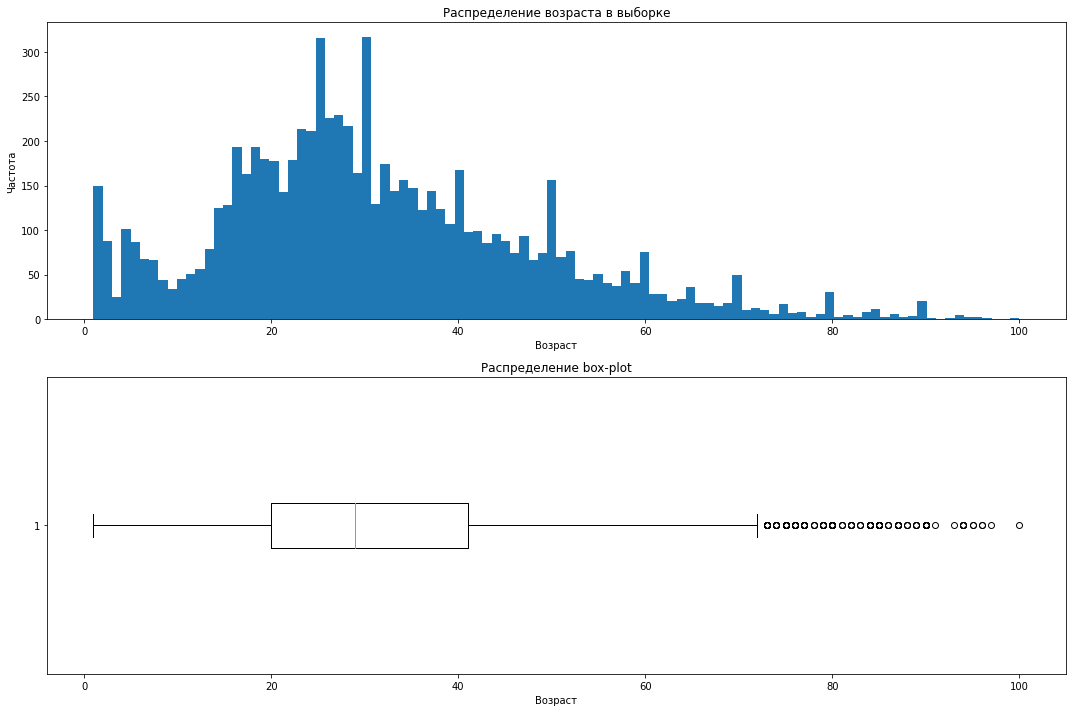

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(15, 10)

ax1.hist(x=labels['real_age'], bins=100)
ax1.set_title('Распределение возраста в выборке')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')

ax2.boxplot(labels['real_age'], vert=False)
ax2.set_title('Распределение box-plot')
ax2.set_xlabel('Возраст')

plt.tight_layout()
plt.show()

На графиках так же видно, что распределение смещенно. Большинство данных в диапазоне от 20 до 40 лет

Посмотрим на приверы фотографий

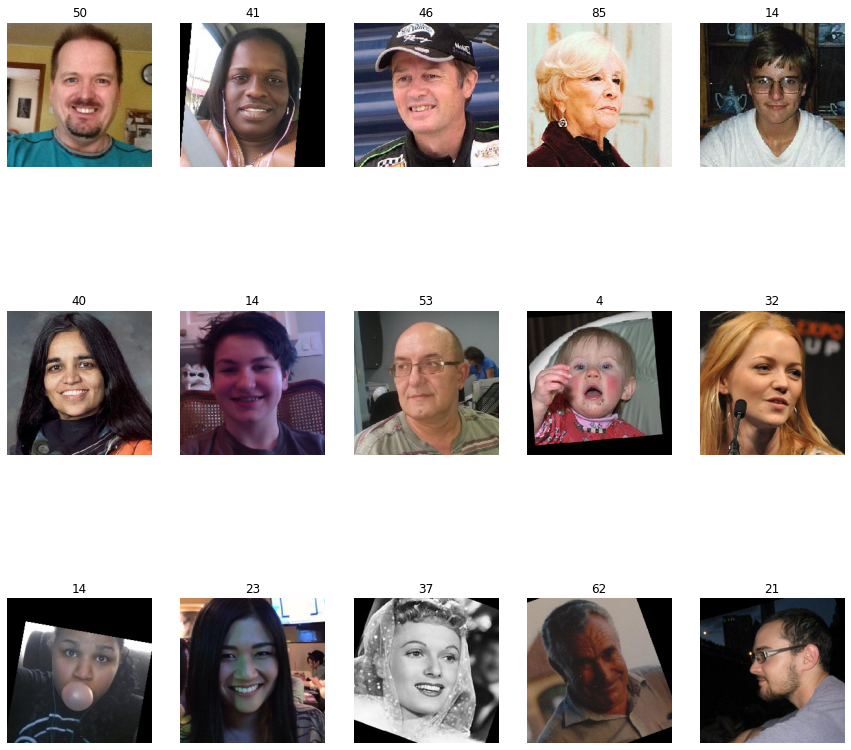

In [4]:
x, y = next(train_gen_flow)
raw = 3; col = 5

plt.figure(figsize=(15, 15))
for i in range(raw*col):
    plt.subplot(raw,col,i+1)
    plt.title(y[i])
    plt.axis('off')
    plt.imshow(x[i])
plt.show()

### Вывод

* Данные без пропусков и нулевых значений 
* Фото мужчин и женщин в профиль и анфас, от 1 до 100 лет
* Присутствуют как цветные так и черно-белые фото
* В выборке присутствует смещение, большинство данных находится в диапазоне от 20 до 40 лет
* Ожидается ухудшение прдесказаний за пределами диапазона
* Есть предположение, что фото пытались выровнять по оси лица

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping


def load_train(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'

    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255.,
    horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=dataframe,
    directory=directory,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)

    return train_datagen_flow

def load_test(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'


    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=dataframe,
    directory=directory,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.00005)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                      metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    callback = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1, callbacks=[callback],
              shuffle=True)

    return model

```

```

Результат вывода

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/50
356/356 - 156s - loss: 239.6651 - mae: 11.1973 - val_loss: 711.0099 - val_mae: 21.7246
Epoch 2/50
356/356 - 37s - loss: 77.5954 - mae: 6.7171 - val_loss: 175.7179 - val_mae: 9.6777
Epoch 3/50
356/356 - 37s - loss: 53.7281 - mae: 5.6253 - val_loss: 73.6060 - val_mae: 6.4719
Epoch 4/50
356/356 - 37s - loss: 40.9170 - mae: 4.9465 - val_loss: 75.5455 - val_mae: 6.6576
Epoch 5/50
356/356 - 37s - loss: 31.2027 - mae: 4.2601 - val_loss: 112.4154 - val_mae: 7.9675
Epoch 6/50
356/356 - 37s - loss: 26.4672 - mae: 3.9661 - val_loss: 68.1382 - val_mae: 6.1311
Epoch 7/50
356/356 - 37s - loss: 21.8217 - mae: 3.5408 - val_loss: 66.9211 - val_mae: 6.1132
Epoch 8/50
356/356 - 37s - loss: 16.8742 - mae: 3.1470 - val_loss: 68.4500 - val_mae: 6.1999
Epoch 9/50
356/356 - 38s - loss: 13.6458 - mae: 2.8269 - val_loss: 65.1401 - val_mae: 6.0420
Epoch 10/50
356/356 - 37s - loss: 11.7381 - mae: 2.6003 - val_loss: 64.4692 - val_mae: 6.0739
Epoch 11/50
356/356 - 37s - loss: 10.3152 - mae: 2.4384 - val_loss: 65.2152 - val_mae: 6.0901
Epoch 12/50
356/356 - 37s - loss: 9.6442 - mae: 2.3516 - val_loss: 63.1746 - val_mae: 5.9711
Epoch 13/50
356/356 - 37s - loss: 9.5058 - mae: 2.3100 - val_loss: 66.2980 - val_mae: 6.0195
Epoch 14/50
356/356 - 38s - loss: 8.8466 - mae: 2.2563 - val_loss: 64.7903 - val_mae: 5.9419
Epoch 15/50
356/356 - 37s - loss: 8.5019 - mae: 2.2086 - val_loss: 61.3902 - val_mae: 5.7973
Epoch 16/50
356/356 - 37s - loss: 8.3323 - mae: 2.1602 - val_loss: 62.5408 - val_mae: 5.8060
Epoch 17/50
356/356 - 37s - loss: 8.0399 - mae: 2.1391 - val_loss: 62.7718 - val_mae: 5.9719
Epoch 18/50
356/356 - 37s - loss: 8.0322 - mae: 2.1571 - val_loss: 69.2589 - val_mae: 6.3059
Epoch 19/50
356/356 - 37s - loss: 7.8679 - mae: 2.1265 - val_loss: 75.7535 - val_mae: 6.3284
Epoch 20/50
356/356 - 37s - loss: 7.9951 - mae: 2.1304 - val_loss: 65.8473 - val_mae: 5.9201
Epoch 21/50
356/356 - 37s - loss: 7.3514 - mae: 2.0351 - val_loss: 62.1692 - val_mae: 5.9375
Epoch 22/50
356/356 - 37s - loss: 6.7569 - mae: 1.9695 - val_loss: 64.5828 - val_mae: 5.9592
Epoch 23/50
356/356 - 37s - loss: 6.9836 - mae: 1.9865 - val_loss: 67.6318 - val_mae: 6.3586
Epoch 24/50
356/356 - 37s - loss: 6.6270 - mae: 1.9511 - val_loss: 58.3121 - val_mae: 5.7544
Epoch 25/50
356/356 - 37s - loss: 6.0395 - mae: 1.8720 - val_loss: 61.3708 - val_mae: 5.8838
Epoch 26/50
356/356 - 38s - loss: 5.7157 - mae: 1.8011 - val_loss: 59.6375 - val_mae: 5.6612
Epoch 27/50
356/356 - 37s - loss: 5.4780 - mae: 1.7807 - val_loss: 57.7396 - val_mae: 5.6960
Epoch 28/50
356/356 - 37s - loss: 5.6479 - mae: 1.7938 - val_loss: 59.9426 - val_mae: 5.7378
Epoch 29/50
356/356 - 37s - loss: 5.1355 - mae: 1.7152 - val_loss: 57.9801 - val_mae: 5.6970
Epoch 30/50
356/356 - 37s - loss: 5.1906 - mae: 1.7153 - val_loss: 59.2892 - val_mae: 5.7360
Epoch 31/50
356/356 - 38s - loss: 5.0757 - mae: 1.7125 - val_loss: 61.9931 - val_mae: 5.8261
Epoch 32/50
356/356 - 37s - loss: 5.1587 - mae: 1.7195 - val_loss: 60.9695 - val_mae: 5.7269
Epoch 33/50
356/356 - 37s - loss: 5.1858 - mae: 1.7133 - val_loss: 56.8620 - val_mae: 5.5844
Epoch 34/50
356/356 - 37s - loss: 4.6419 - mae: 1.6288 - val_loss: 60.2797 - val_mae: 5.8361
Epoch 35/50
356/356 - 37s - loss: 4.7560 - mae: 1.6303 - val_loss: 57.4867 - val_mae: 5.6917
Epoch 36/50
356/356 - 38s - loss: 4.2772 - mae: 1.5770 - val_loss: 55.8737 - val_mae: 5.5235
Epoch 37/50
356/356 - 37s - loss: 3.9558 - mae: 1.5026 - val_loss: 55.8593 - val_mae: 5.5657
Epoch 38/50
356/356 - 38s - loss: 4.1573 - mae: 1.5447 - val_loss: 56.9087 - val_mae: 5.5123
Epoch 39/50
356/356 - 37s - loss: 4.0412 - mae: 1.5292 - val_loss: 58.1080 - val_mae: 5.6774
Epoch 40/50
356/356 - 37s - loss: 4.1992 - mae: 1.5567 - val_loss: 58.3437 - val_mae: 5.7687
Epoch 41/50
356/356 - 37s - loss: 3.8967 - mae: 1.4917 - val_loss: 56.8633 - val_mae: 5.6447
Epoch 42/50
356/356 - 37s - loss: 3.5283 - mae: 1.4295 - val_loss: 57.4503 - val_mae: 5.5995
Epoch 43/50
356/356 - 38s - loss: 3.6327 - mae: 1.4501 - val_loss: 55.3431 - val_mae: 5.5082
Epoch 44/50
356/356 - 37s - loss: 3.8109 - mae: 1.4675 - val_loss: 57.1955 - val_mae: 5.5847
Epoch 45/50
356/356 - 37s - loss: 3.7266 - mae: 1.4482 - val_loss: 56.0765 - val_mae: 5.4923
Epoch 46/50
356/356 - 37s - loss: 3.8673 - mae: 1.4646 - val_loss: 54.9369 - val_mae: 5.4996
Epoch 47/50
356/356 - 37s - loss: 3.5710 - mae: 1.4250 - val_loss: 56.6876 - val_mae: 5.5553
Epoch 48/50
356/356 - 37s - loss: 3.3236 - mae: 1.3630 - val_loss: 56.6814 - val_mae: 5.6191
Epoch 49/50
356/356 - 37s - loss: 3.3659 - mae: 1.3966 - val_loss: 56.9592 - val_mae: 5.6484
Epoch 50/50
356/356 - 37s - loss: 3.0373 - mae: 1.3020 - val_loss: 55.4253 - val_mae: 5.4513

119/119 - 9s - loss: 55.4253 - mae: 5.4513
Test MAE: 5.4513

```

## Анализ обученной модели

* Метод аугментации был выбран подходяший для лиц - отражение по горизонтали
* Использовалась готовая CNN ResNet50 предобученная на Imagenet
* Так как модель нужно было дообучить, шаг обучения был снижен до 0.00005
* Тип активации на последнем слое был выбран ReLU т.к. возраст не должен быть меньше нуля
* Так как стояла задача регресии нейрон на выходе один
* В результате была получена метрика MAE: 5.4513, подходящая под заданное условие
* Модель подходит для задачи определения возрасной группы, но при средней ошибке в 5.5 лет контроль за продажей алкоголя будет проблематичен